In [6]:
import os
import numpy as np 
import healpy as hp 

import matplotlib.pyplot as plt 
from matplotlib import cm, rcParams
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

rcParams["figure.figsize"]=(7,5)
rcParams["figure.dpi"]=100
rcParams["font.size"]=16
rcParams["font.family"]="stix"
rcParams["text.usetex"]=True


h_over_k = 0.047992447 #:[K*s]
h_over_c2 = 7.3724972E-4 #: [MJy/sr/GHz^3]
k3_over_c2h2 = 6.66954097 # :[MJy/sr]
c2_over_k = 65.096595 # :[K*GHz^2/MJy/sr]

In this notebook I will derive the relavant formulae for converting thermodynamic temperature and intensity and brightness temperature of a black body. 

To see a summary of all the formulae for converting absolute and differential measurements see section [2. Summary](#summary).

If you are only interested to learn about the unit conversion module, jump to section [3. Python Unit Conversion Module](#unit_conversion).

# Black Body Radiation

## Specific Intensity 

### analytical expressions

Intensity of a **black body** radiating at the _thermodynamic temperature_ $T$ can be described in terms of the Planck function $B_\nu(T)$:

\begin{align*}
    I_\nu &= B_\nu (T)\\
              &= \frac{2 h}{c^2} \frac{\nu^3}{e^{h \nu / kT}-1}\\
              &= \frac{2 k^3 T^3}{c^2 h^2} \frac{x^3}{e^{x}-1}\\
\end{align*}

\begin{equation}
    \boxed{I_\nu (T) = \frac{2 k^3 T^3}{c^2 h^2} \frac{x^3}{e^{x}-1}}\\
\end{equation} 

where $\nu$ is the observed frequency and $x \equiv h \nu / kT \simeq \nu/56.8 ~\rm GHz$ (for the CMB) is the dimensionless frequency. $k, h,$ and $c$ are respectively the Boltzmann constant, Planck constant and speed of light. 

For the CMB, this equation holds in every direction in the sky $\hat n$ (or every pixel in a CMB map):

\begin{align*}
    I_\nu (\hat n) &= B_\nu (T(\hat n)),
\end{align*}

which can be expanded around the average temperature in the sky $T_0$ as 

\begin{align*}
    I_\nu (\hat n) &= B_\nu (T_0 + \delta T(\hat n))\\
    I_{\nu,0} (\hat n) + \delta I_\nu (\hat n) &= B_\nu (T_0) + \frac{\partial B_\nu (T_0)}{\partial T}\delta T
\end{align*}

Most of the information in the CMB is contained in the anisotropies, so practically what we are interested in is $\delta T$ which is not directly observable, but can be infered from the observable intensity anisotropies $\delta I_\nu$. 

The frequency function of intensity fluctuations can be described by the **differential black body** ($F_\nu(T_0)$) radiation:

\begin{align*}
    \delta I_\nu  &= \frac{\partial B_\nu (T)}{\partial T}\Big|_{T=T_0}\delta T\\
                     &= F_\nu (T_0)\frac{\delta T}{ T_0}\\
              &= B_\nu (T_0)\frac{x e^x}{ e^x-1}\frac{\delta T}{ T_0}\\
\end{align*}

\begin{equation}
    \boxed{\delta I_\nu  = \frac{2 k^3 T_0^3}{c^2 h^2} \frac{x^4 e^x}{ (e^x-1)^2}\frac{\delta T}{ T_0}}\\
\end{equation}    

Let's define two functions for the black body spectrum and the differential black body spectrum:

In [2]:
def black_body(nu, T):
    """
    BB spectrum [MJy/sr] with a temperature T [K] at frequency nu [GHz]

    :param nu: observed frequency [GHz]
    :param T: thermodynamic temperature [K]
    :return: I_nu [MJy/sr]
    """
    
    x = h_over_k * nu / T  # nu: [GHz] ; T: [K]
    g = x ** 3 / np.expm1(x)
    return 2 * k3_over_c2h2 * T ** 3 * g



def diff_black_body(nu, T):
    """
    differential BB spectrum [MJy/sr] with a temperature T [K] at frequency nu [GHz]
    ***multiply by dT/T to get dI_nu***

    :param nu: observed frequency [GHz]
    :param T: thermodynamic temperature [K]
    :return: dI_nu*T/dT [MJy/sr]
    """
    
    x = h_over_k * nu / T  # nu: [GHz] ; T: [K]
    f = x ** 4 * np.exp(x) / np.expm1(x) ** 2

    return 2 * k3_over_c2h2 * T ** 3 * f

### frequency spectra

The black body and differential blackbody spectra peak at different frequencies. In order to see this, we can plot the two frequency spectra for the CMB with the average thermodynamic temperature $T_{0}=2.7255~\rm K$.

In [3]:
# set the average temperature 
T_0 = 2.7255 #:[K]

# set the frequency range
nu_min = 1 #:[GHz] start from 1 to avoid NaN values 
nu_max = 1000 #:[GHz]
N_nu = 4000 #number of points in the plot. 
            #This is set to a high number in order to find the peaks accurately. 

# arange an array of values for the frequency
nu_arr = np.linspace(nu_min,nu_max,N_nu) #:[GHz]

# define the frequency spectra 
B_nu = black_body(nu_arr,T_0)
F_nu = diff_black_body(nu_arr,T_0)

# find the maxima
nu_B_nu_max = nu_arr[np.argmax(B_nu)]
nu_F_nu_max = nu_arr[np.argmax(F_nu)]

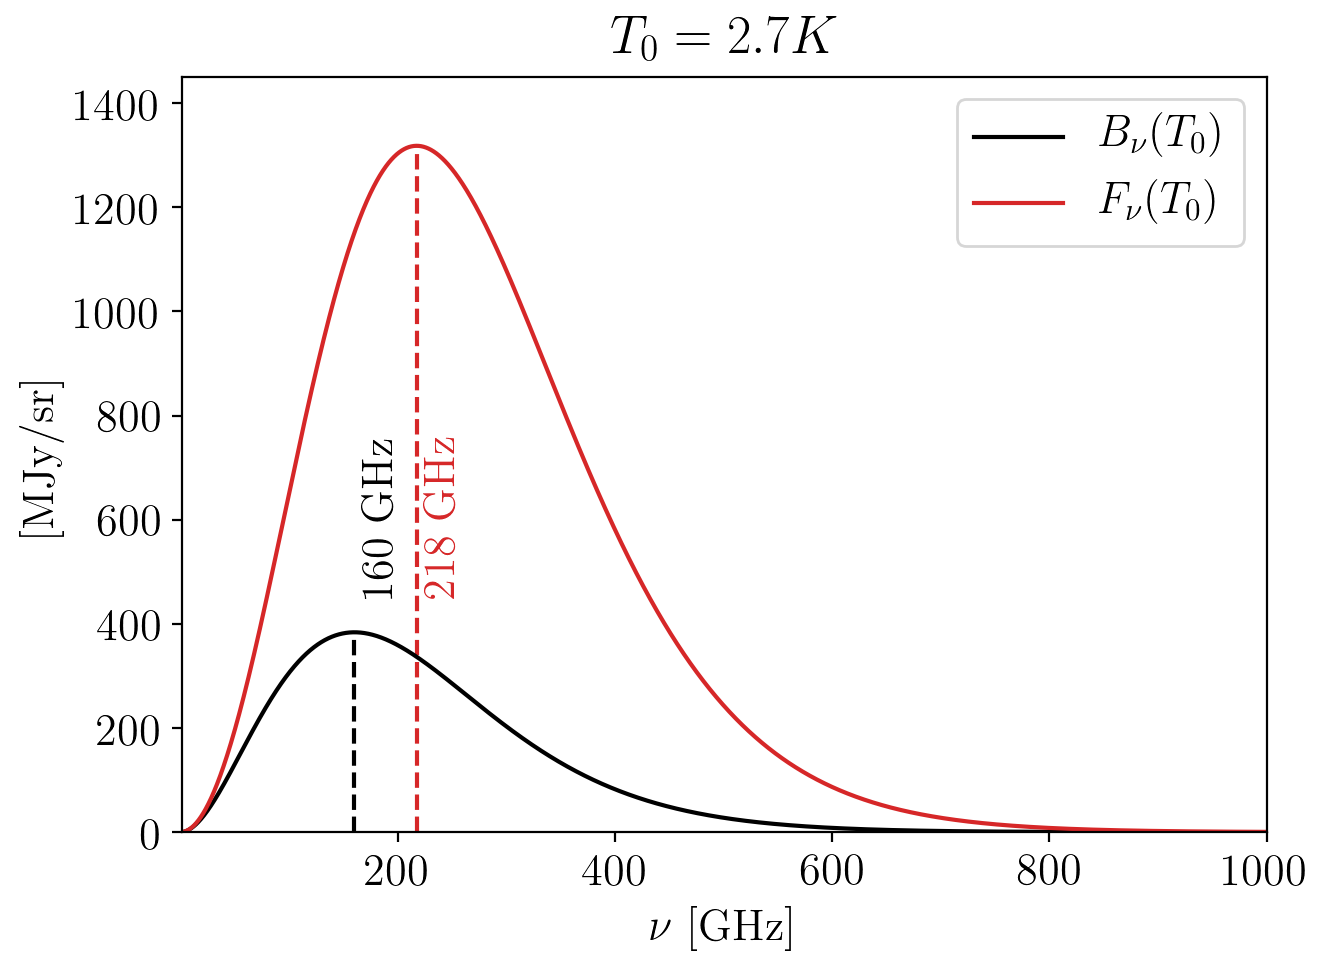

In [25]:
plt.plot(nu_arr,B_nu,color='k',label=r'$B_\nu (T_0)$')
plt.plot(nu_arr,F_nu,color='tab:red',label=r'$F_\nu (T_0)$')

plt.vlines(nu_B_nu_max,0,max(B_nu),color='k',linestyles='dashed')
plt.vlines(nu_F_nu_max,0,max(F_nu),color='tab:red',linestyles='dashed')

plt.text(nu_B_nu_max+5,700,"{:.0f} GHz".format(nu_B_nu_max),rotation=90)
plt.text(nu_F_nu_max+5,700,"{:.0f} GHz".format(nu_F_nu_max),rotation=90,color='tab:red')

plt.title(r"$T_0 = {:.1f} K$".format(T_0))

plt.ylabel("[MJy/sr]")
plt.xlabel(r"$\nu$ [GHz]")

plt.xlim(nu_min,nu_max)
plt.ylim(0,1.1*max(F_nu))

_=plt.legend()

### differential measurement on simulated pixel

To confirm the theoretical calculations for the differential BB spectrum, we can simulate a pixel with a temperature slightly higher than the average. This pixel would have a spectrum equal to $B_\nu(T_0 + \delta T)$, which is a black body. But after subtracting the average BB with the spectrum $B_\nu(T_0)$, what remains is $B_\nu(T_0 + \delta T)-B_\nu(T_0)$, which is **NOT** a black body, but a differential black body! Hence its frequency spectrum will be equal to $F_\nu(T_0)$. Let's check this fact:

In [8]:
# define an arbitrary temperature increment
dT = 10E-6 #[K] ; 10 uK fluctuation

# set the frequency channels. Let's say we have 20 of them between 0 to 850 GHz
nu_chanl = np.linspace(1,850,20)

# simulate a pixel with slightly higher temperature than average
B_nu_pix = black_body(nu_chanl, T_0+dT)
# and the black body with the average temperature T_0
B_nu_pix0 = black_body(nu_chanl, T_0)

# subtract the average intensity from the pixel 
dB_nu_pix = B_nu_pix - B_nu_pix0

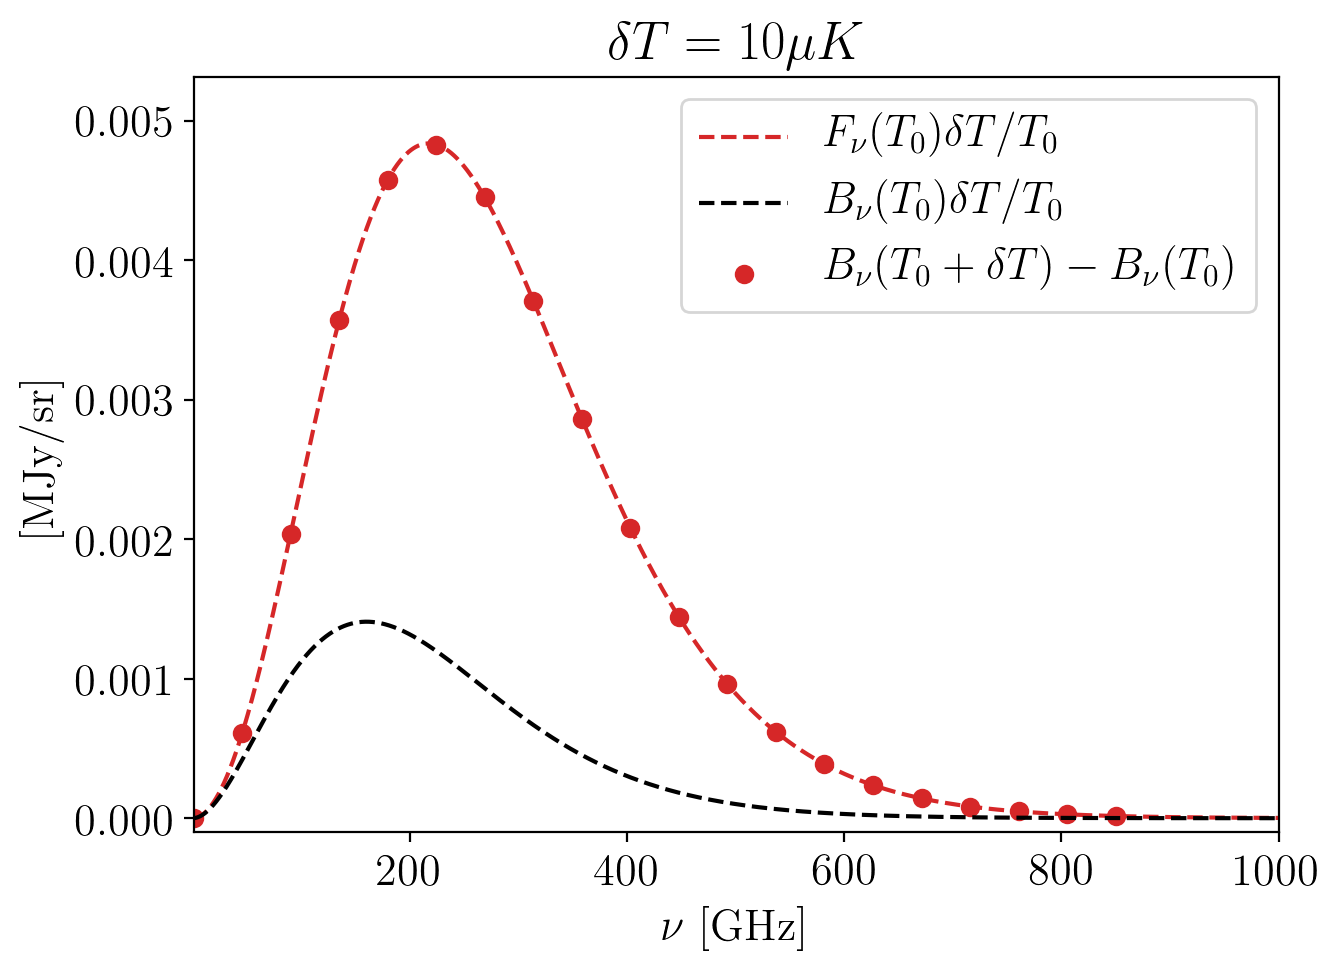

In [24]:
plt.scatter(nu_chanl,dB_nu_pix,color='tab:red',label=r'$B_\nu (T_0+\delta T)-B_\nu (T_0)$')
plt.plot(nu_arr,F_nu*dT/T_0,color='tab:red',label=r'$F_\nu (T_0)\delta T/T_0$',linestyle="--")

plt.plot(nu_arr,dT*B_nu/T_0,color='k',label=r'$B_\nu (T_0)\delta T/T_0$',linestyle="--")

plt.title(r"$\delta T = {:.0f} \mu K$".format(1E6*dT))

plt.ylabel("[MJy/sr]")
plt.xlabel(r"$\nu$ [GHz]")

plt.xlim(nu_min,nu_max)
plt.ylim(-1E-4,1.1*max(dB_nu_pix))

_=plt.legend()

Clearly the processed pixels (average subtracted) have a differential BB spectrum, not BB.

## Brightness Temperature

### analytical expressions

Since we are ultimately interested in measuring the temperature of each pixel (rather than the observed intensity), it would be helpful to have formulas that convert the latter into the former. An easy way to do this conversion is to use the notion of **brightness temperature**. 


Brightness temperature can be expressed in terms of the specific intensity by inverting the black body equation. This yields 

\begin{equation}\label{bright}
    \boxed{T_b(\nu) = \frac{h \nu}{k} \log^{-1}\left[ 1 + \frac{2 h \nu^3/c^2}{I_\nu(T)}\right]},
\end{equation}

which for a pure black body is constant and equal to the thermodynamic temperature ($T_b(\nu) = T$). 

In the Rayleigh-Jeans limit where $h \nu \ll k T$, the brightness temperature is approximately

\begin{equation}
    \boxed{T_{RJ}(\nu) \simeq\frac{I_\nu c^2}{2 k \nu^2} }.
\end{equation}

This is a useful equation, because it provides a linear transformation between the intensity and a temperature-like parameter; which happens to be also equal to the thermodynamic temperature at low frequencies. Brightness temperature in this limit is often denoted as $T_{RJ}$. 

Using this expression, pixel to pixel intensity fluctuations can be converted to Rayleigh-Jeans brightness temperature fluctuation: 


\begin{equation}
    \delta T_{RJ}(\nu) \simeq\frac{\delta I_\nu c^2}{2 k \nu^2} .
\end{equation}

As mentioned earlier, this is not exactly equal to the thermodynamic temperature—as is the case for brightness temperature—which is the quantity we are interested in, but it is easy to derive the connection between the two. In order to connect the Rayleigh-Jeans temperature (observed) to the underlying brightness temperature (and hence thermodynamic temperature for a black body) we can eaily replace $\delta I_\nu$ from the previous section and find 

\begin{equation}
    \boxed{\delta T_{RJ}(\nu) =\frac{ x^2 e^x}{(e^x-1)^2} \delta T_b(\nu) }.
\end{equation}

for the sake of completeness, let's also calculate the conversion between intensity fluctuations and temperature fluctuations outside of the Rayleigh Jeans limit (derivative of Eq. \eqref{bright}).


\begin{equation}
    \boxed{\delta T_b(\nu) = \frac{ h^2 \nu^4}{c^2 k I_{\nu,0}} \left(1+\frac{2h\nu^3}{c^2 I_{\nu,0}}\right)^{-1}
    \log^{-1}\left[1+\frac{2h\nu^3}{c^2 I_{\nu,0}} \right] \frac{\delta I_\nu}{I_{\nu,0}}},
\end{equation}
where $I_{\nu,0}$ is the average intensity of the radiation that $\delta I_\nu$ is fluctuating around. For a pure black body this expression is not frequency dependent and is equal to the thermodynamic temperature fluctuations ($\delta T_b(\nu) = \delta T$). 

It's straight forward to derive the remaining conversion formulas from these equations, using integration/substitution etc. **Check out the summary section for a complete list of conversion formulas.**

Now let's see how we can convert the observables $I_\nu$ and $\delta I_\nu$ to their temperature equivalents. 

In [12]:
def bright_temp(nu, I_nu, RJ=False):
    """
    Thermodynamic temperature T [K] at frequency nu [GHz] for the observed intensity [MJy/sr]
    if RJ==True, return brightness temperature

    :param nu: observed frequency [GHz]
    :param I_nu: specific intensity [MJy/sr]
    :param RJ: if True, output is RJ temperature
    :return: T [K]
    """

    if RJ:
        return I_nu * c2_over_k / 2 / nu ** 2

    else:
        return h_over_k * nu / np.log(1 + 2 * h_over_c2 * nu ** 3 / I_nu)


def diff_black_body(nu, T, RJ=False):
    """
    differential BB spectrum [MJy/sr] with a temperature T [K] at frequency nu [GHz]
    ***multiply by dT/T to get dI_nu***

    :param nu: observed frequency [GHz]
    :param T: brightness temperature [K]
    :param RJ: if True, input is RJ temperature
    :return: dI_nu*T/dT [MJy/sr]
    """

    if RJ:
        return 2/c2_over_k * nu**2 *T

    else:
        x = h_over_k * nu / T  # nu: [GHz] ; T: [K]
        f = x ** 4 * np.exp(x) / np.expm1(x) ** 2

        return 2 * k3_over_c2h2 * T ** 3 * f
    

And for the brightness ($\delta T_b$) and RJ temperature fluctuations ($\delta T_{RJ}$) we have:

In [13]:
def dT_bright2RJ(nu, T):
    """the frequency function for converting brightness temperature fluctuation
    to the RJ limit.
    ***Multiply by dT/T to get dT_b***

    :param nu: observed frequency [GHz]
    :param T: brightness temperature [K]
    :return: dT_RJ*T/dT  [K]
    """

    x = h_over_k * nu / T  # nu [GHz] ; t [#K]

    g = x ** 2 * np.exp(x) / np.expm1(x) ** 2

    return g * T


### frequency spectra

First let's investigate the frequency dependence of the brightness temperature for the average CMB:

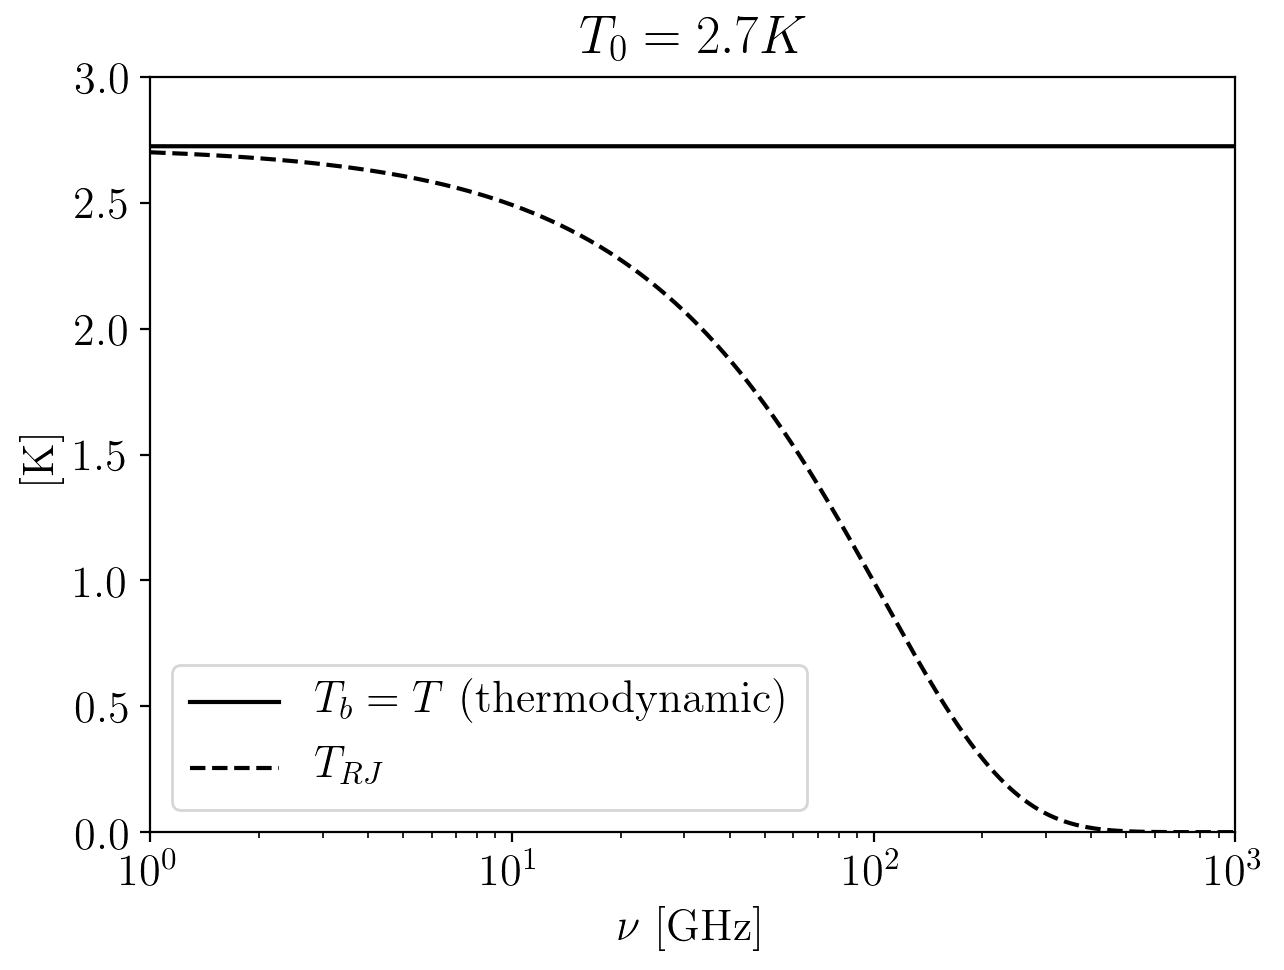

In [22]:
# compare the brightness and thermodynamic temperatures for the black body radiation

#plot the thermodynamic temperature 
plt.semilogx(nu_arr,bright_temp(nu_arr,B_nu,RJ=False),"k",label=r"$T_b = T$ (thermodynamic)")
#plot the brightness temperature (RJ limit)
plt.semilogx(nu_arr,bright_temp(nu_arr,B_nu,RJ=True),"k",linestyle="--",label=r"$T_{RJ}$ ")

plt.title(r"$T_0 = {:.1f} K$".format(T_0))

plt.ylabel("[K]")
plt.xlabel(r"$\nu$ [GHz]")

plt.ylim(0,3)
plt.xlim(1 ,nu_max)

_=plt.legend()

Obviously the Rayleigh-Jeans limit does not hold at higher frequency and hence the deviation of the brightness temperature from the thermodynamic temperature.

### simulated pixel

In order to confirm the frequency function derived for the conversion from $T_b$ to $T_{RJ}$, again we simulate a pixel with a temperature slightly higher than the average CMB temperature. Then we find the difference between this pixel and the average temperature over different frequencies. 

In [17]:
# calculate the differential brightness temperature dT_b
dT_b = dT_bright2RJ(nu_arr,T_0)*dT/T_0

In [18]:
# calculate T_b for the average black body
T_b_pix0 = bright_temp(nu_chanl,B_nu_pix0,RJ=True)
# and the pixel with the slightly higher temperature
T_b_pix = bright_temp(nu_chanl,B_nu_pix,RJ=True)

# subtract the average black body from the pixel
dTb_pix = T_b_pix-T_b_pix0

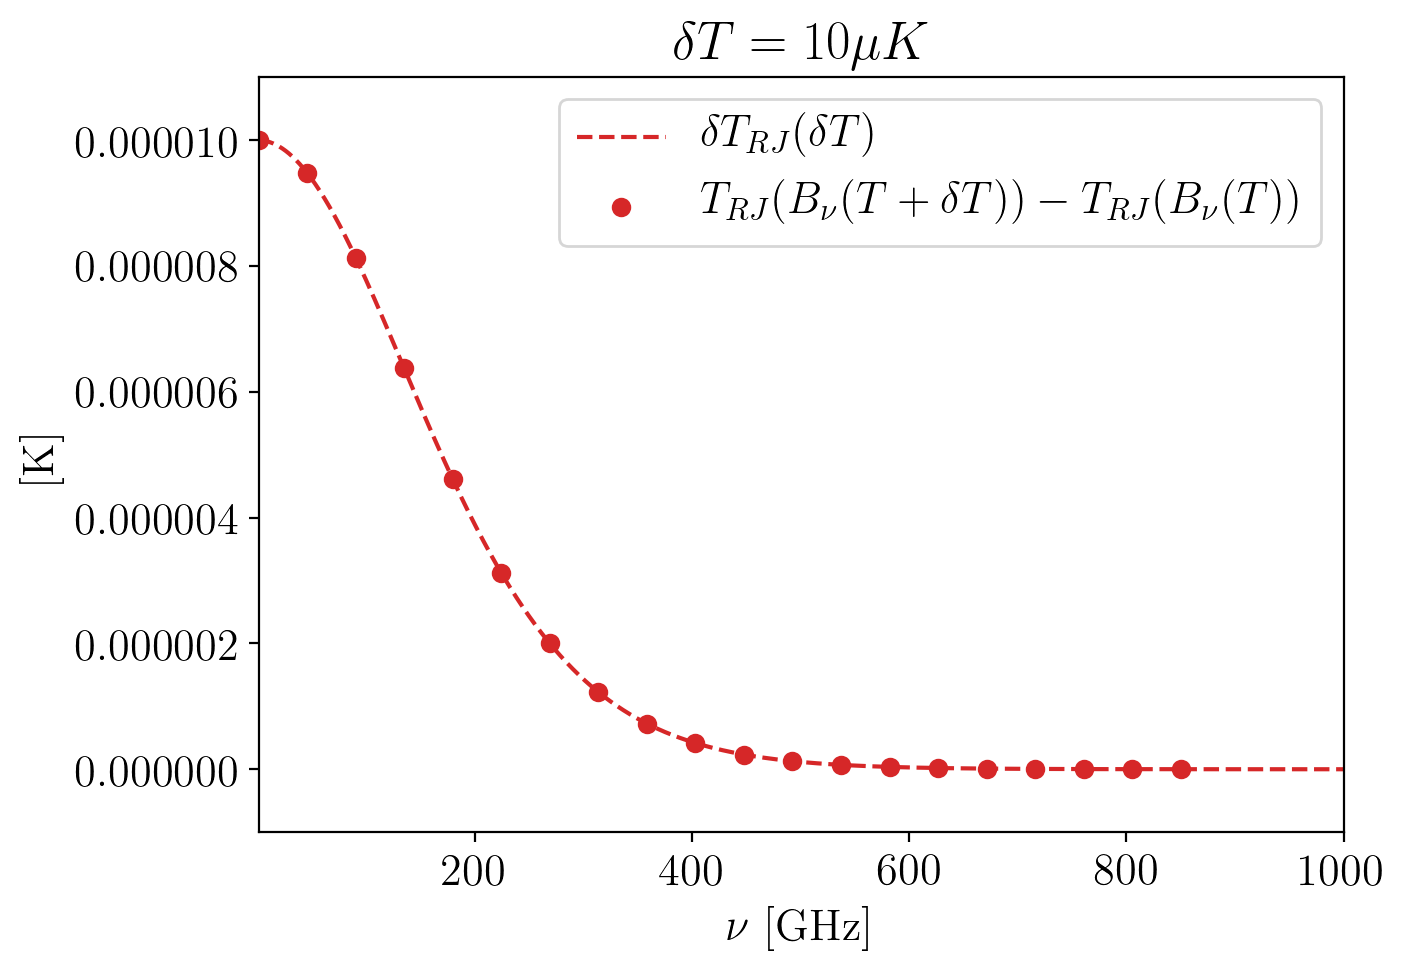

In [23]:
# plot the simulated pixel over the observed frequency channels 
plt.scatter(nu_chanl,dTb_pix,color="tab:red",label=r"$T_{RJ}(B_\nu (T+\delta T))-T_{RJ}(B_\nu (T))$")
# and compare with the analytical calculation
plt.plot(nu_arr,dT_b,color="tab:red",linestyle='--',label=r"$\delta T_{RJ}(\delta T)$")

plt.title(r"$\delta T = {:.0f} \mu K$".format(1E6*dT))

plt.ylabel("[K]")
plt.xlabel(r"$\nu$ [GHz]")

plt.ylim(-1E-6,1.1E-5)
plt.xlim(nu_min,nu_max)

_=plt.legend()

<a id='summary'></a>


# Summary 

Here we summarize all the conversion formulae for easy reference. 

About the notation:

In the context of the CMB you might also see 

$T_{RJ}$ : RJ temperature denoted as $T_{RJ}$ or $s_\nu$

$T$ : brightness temperature denoted as $T$, $T_b$ or $T_{CMB}$


Once again, keep in mind that for a pure blackbody CMB the brightness temperature is frequency independent and equal to the thermodynamic temperature. So in the following we drop the subscript $b$ and frequency dependence $(\nu)$ for simplicity. 

## Absolute measurement (average/monopole included)

### $(I_\nu$  & $T)$ Intensity & Brightness (Thermodynamic) Temperature 


\begin{equation}
    \boxed{I_\nu = \frac{2 k^3 T^3}{c^2 h^2} \frac{x^3}{e^{x}-1}}\\
\end{equation} 


\begin{equation}
    \boxed{T = \frac{h \nu}{k} \log^{-1}\left[ 1 + \frac{2 h \nu^3/c^2}{I_\nu}\right]}
\end{equation}
where $x \equiv h \nu/k T$.

### $(I_\nu$  & $T_{RJ})$ Intensity & RJ Temperature 

\begin{equation}
    \boxed{I_\nu = \frac{2 k \nu^2}{c^2}T_{RJ}(\nu) }
\end{equation} 

\begin{equation}
    \boxed{T_{RJ}(\nu) = \frac{c^2}{2 k \nu^2}I_\nu } 
\end{equation}




### $(T_{RJ}$  & $T)$ RJ Temperature & Brightness Temperature 


\begin{equation}
    \boxed{T_{RJ}(\nu) =\frac{ x}{(e^x-1)} T }
\end{equation}


\begin{equation}
    \boxed{T =\frac{ x_{RJ}}{\log(1+x_{RJ})} T_{RJ}(\nu) }
\end{equation}
where $x_{RJ} \equiv h \nu/k T_{RJ}$.

## Differential measurement (average/monopole subtracted)

**NOTE**: As it is evident from the formulae, the frequency function of differential transformations depend on the average temperature/intensity of the input map so it has to be provided as an additional argument. The only exception to this is the linear transformation between $I_\nu$ and $T_b$.

**The following expressions are only valid to first order expansion in the perturbation parameters $\delta T/T$, $\delta T_{RJ}/T_{RJ}$, and $\delta I/I$**

### $(\delta I_\nu$  & $\delta T)$ Intensity & Brightness Temperature 


\begin{equation}
    \boxed{\delta I_\nu  = \frac{2 k^3 T_0^3}{c^2 h^2} \frac{x^4 e^x}{ (e^x-1)^2}\frac{\delta T}{ T_0}}\\
\end{equation}    


\begin{equation}
    \boxed{\delta T = \frac{ h^2 \nu^4}{c^2 k I_{\nu,0}} \left(1+\frac{2h\nu^3}{c^2 I_{\nu,0}}\right)^{-1}
    \log^{-1}\left[1+\frac{2h\nu^3}{c^2 I_{\nu,0}} \right] \frac{\delta I_\nu}{I_{\nu,0}}},
\end{equation}

where $x \equiv h \nu/k T_0$ and $T_0$ is the brightness temperature sky-average (monopole/$\sqrt{4 \pi}$).

### $(\delta I_\nu$  & $\delta T_{RJ})$ Intensity & RJ Temperature 

\begin{equation}
    \boxed{\delta I_\nu = \frac{2 k \nu^2}{c^2}\delta T_{RJ}(\nu) }
\end{equation} 

\begin{equation}
    \boxed{\delta T_{RJ}(\nu) = \frac{c^2}{2 k \nu^2}\delta I_\nu } 
\end{equation}




### $(\delta T_{RJ}$  & $\delta T)$ RJ Temperature & Brightness Temperature 


\begin{equation}
    \boxed{\delta T_{RJ}(\nu) =\frac{ x^2 e^x}{(e^x-1)^2} \delta T }.
\end{equation}


\begin{equation}
    \boxed{\delta T =\frac{ x^2_{RJ}}{(1+x_{RJ})\log^2(1+x_{RJ})} \delta T_{RJ}(\nu) }.
\end{equation}
where again $x_{RJ} \equiv h \nu/k T_{RJ,0}$ and $T_{RJ, 0}$ is the RJ temperature sky-average (monopole/$\sqrt{4 \pi}$).

All these functions are included in `lib/unit_conversion.py`

<a id='unit_conversion'></a>


# Python Unit Conversion Module 

## single pixel 

The module `lib/unit_conversion.py` has a convenient unit conversion function called `convert_units_of` that takes in a map/pixel with a certain unit (say $T$) and returns a map/pixel in another unit (say $I_\nu$). Here's how it can be used:

In [36]:
from lib.unit_conversion import convert_units_of
%load_ext autoreload 
%autoreload 2

Let's say we have a black body pixel with the average emperature $T_0 = 2.7255 K$ and $\delta T = 10 \mu K$ and we want to find its intensity and RJ temperature over the frequency range between 1 to 1000 GHz:

In [37]:
T_0 = 2.7255 # [K]
dT = 1E-5 # [K]
nu_arr = np.linspace(1,1000,1000)

We can call the `convert_units_of` function like this:

In [38]:
I_nu = convert_units_of(T_0, from_units="T", to_units="I",
                        at_nu=nu_arr,
                        with_map_avg=None,
                        is_differential=False)

unit_syn= T
unit_syn= I

converting T [K] to I [MJy/sr]
T: brightness (T)emperature
I: specific (I)ntensity



The function simply takes a pixel as input and the input units `from_units` and the expected output unit `to_units`, the observation frequency `at_nu` and the map average `with_map_avg` which is only required for the differential transformations (`is_differential = True`).


The valid keywords for `from_units` and `to_units` are 


| Variable [units] | `keyword` | 
| :---: | :---: |
| Brightness Temperature [K] | `"T", "Tb", "T_cmb", "T_CMB", "K", "K_CMB"` | 
| Specific Intensity [MJy/sr] | `"I", "I_nu", "MJy/sr"` | 
| Rayleigh-Jeans Temperature [K_RJ] | `"T_RJ", "T_rj", "s_nu", "K_RJ", "K_rj"`| 
        
        
       

Now let's try the same for differential intensity and also brightness tempearture

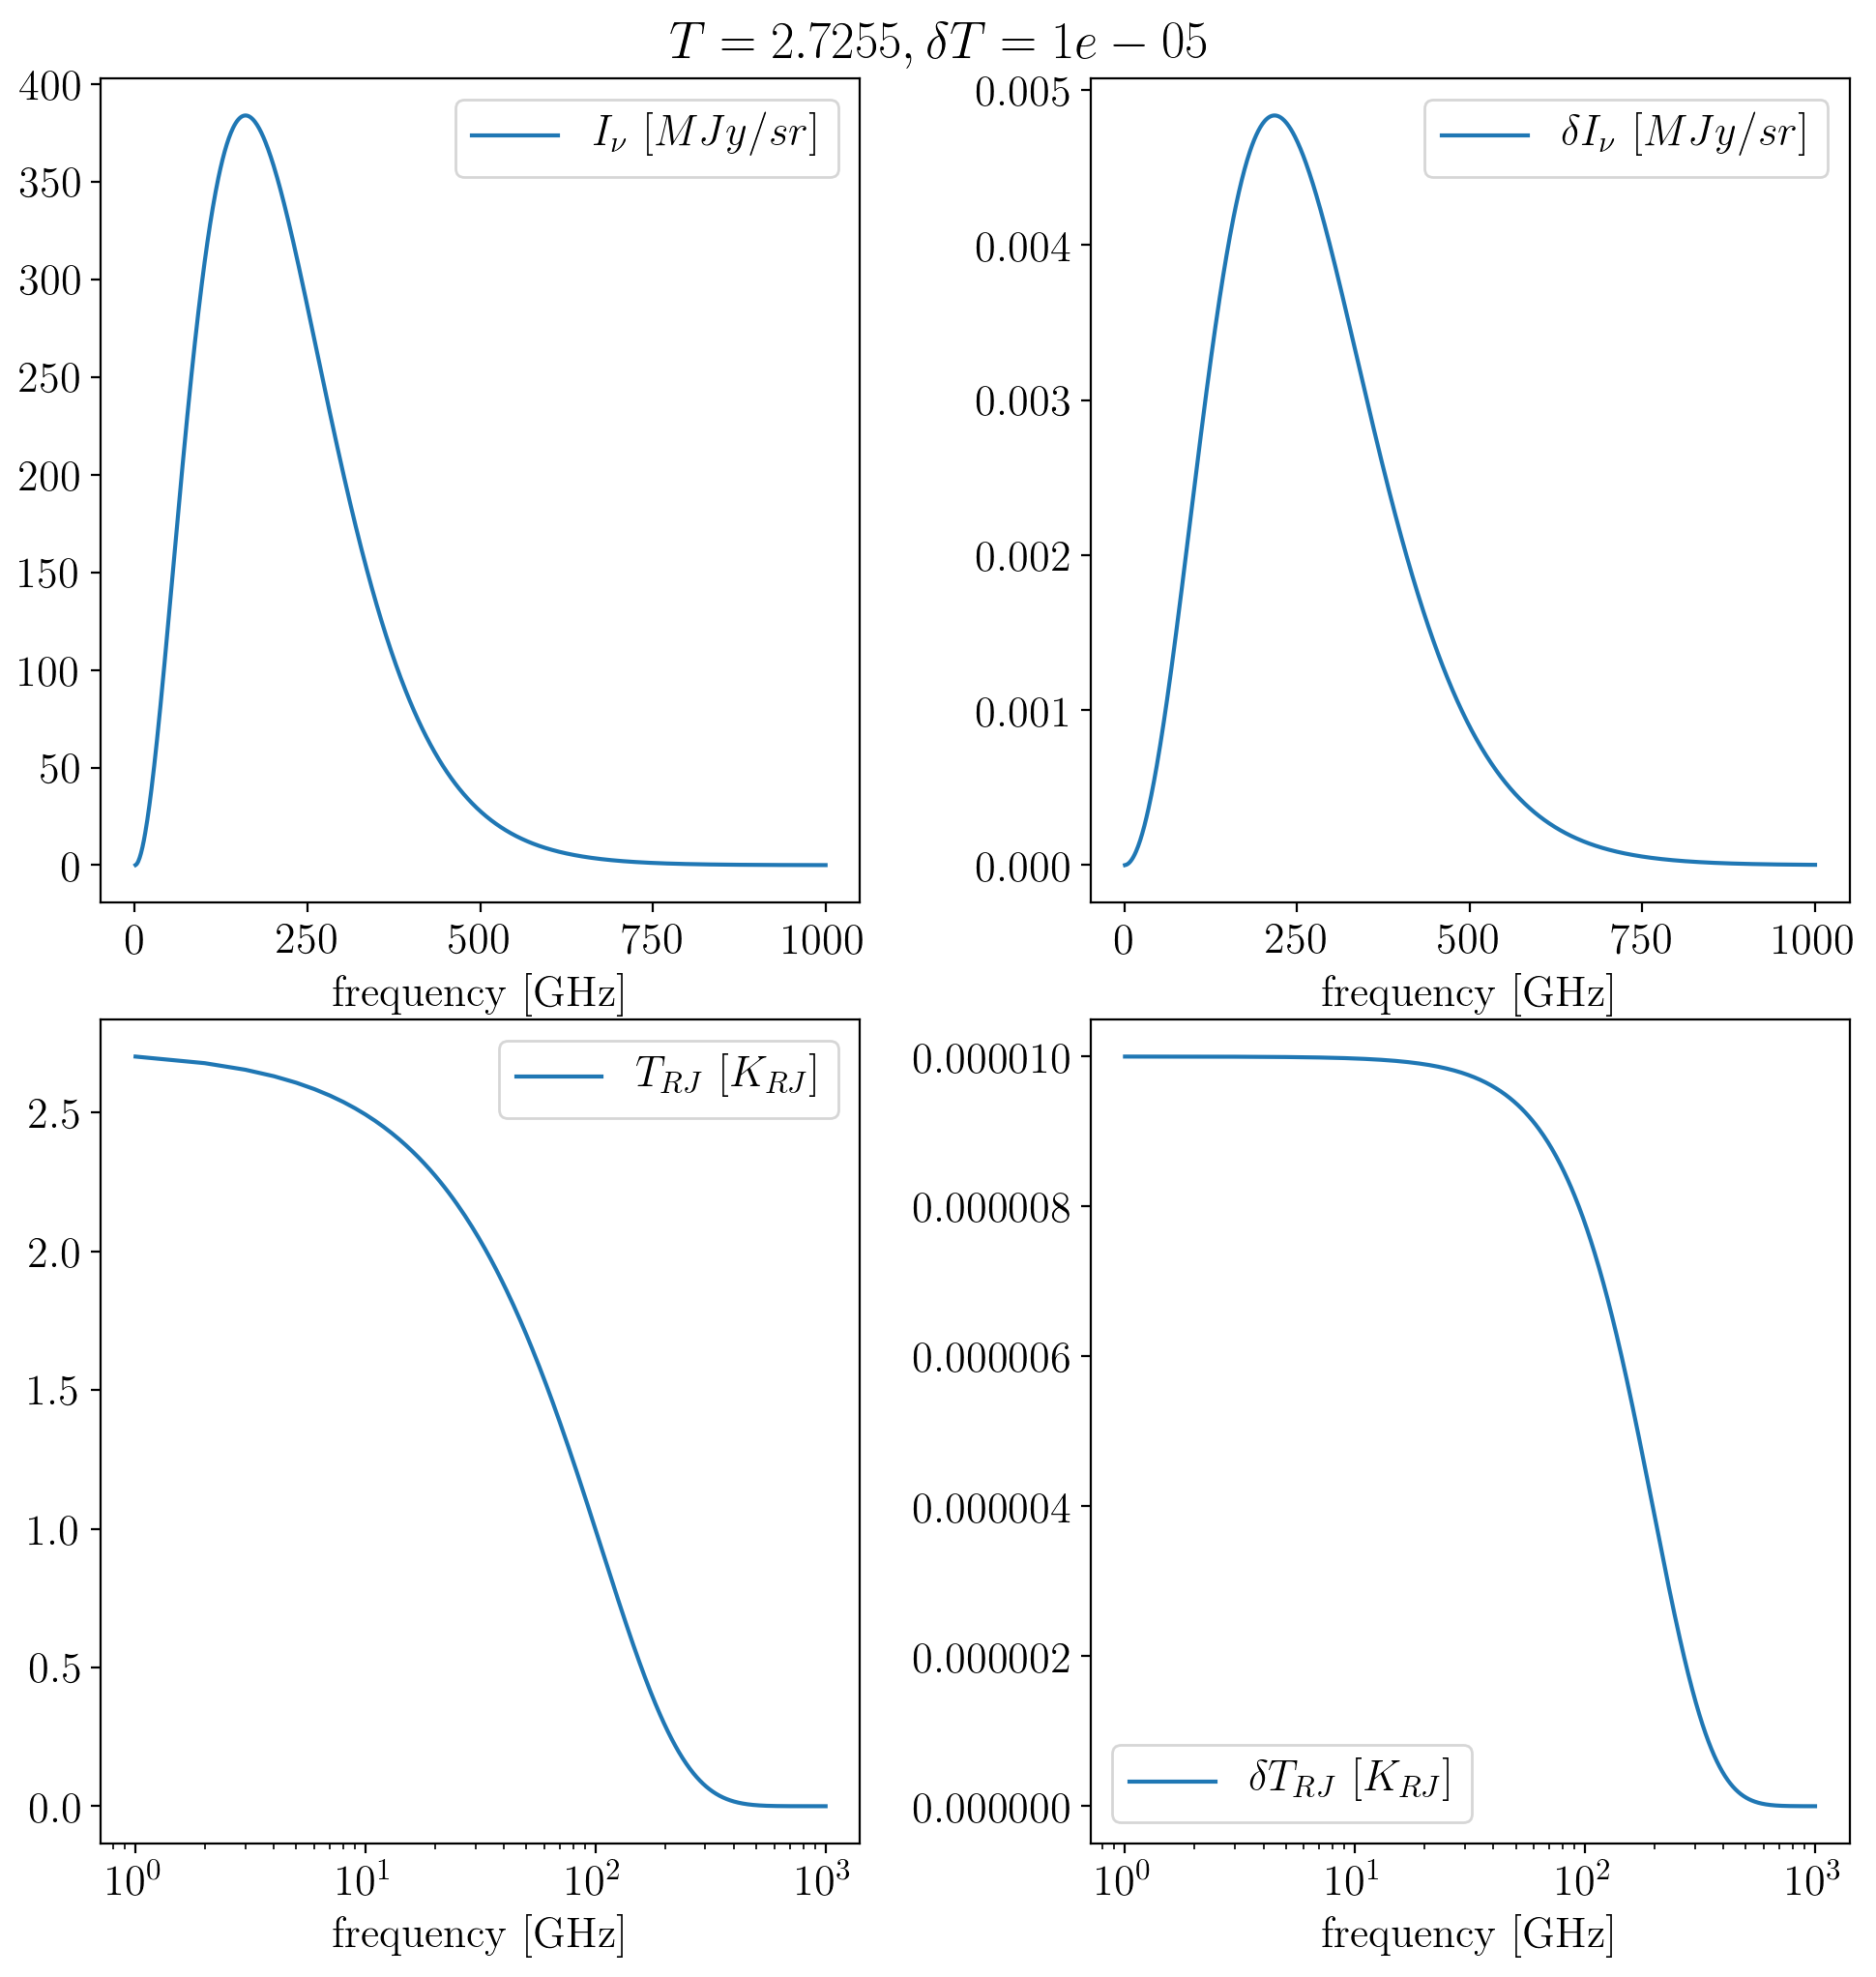

In [52]:
dI_nu = convert_units_of(dT, from_units="T", to_units="I",
                         at_nu=nu_arr,
                         with_map_avg=T_0,
                         is_differential=True,
                         verbose = False)

T_b = convert_units_of(T_0, from_units="T", to_units="T_RJ",
                         at_nu=nu_arr,
                         with_map_avg=None,
                         is_differential=False,
                         verbose= False)

dT_b = convert_units_of(dT, from_units="T", to_units="T_RJ",
                         at_nu=nu_arr,
                         with_map_avg=T_0,
                         is_differential=True,
                         verbose=False)

fig, axis = plt.subplots(2,2,figsize=(10,10),dpi=100)

axis[0,0].plot(nu_arr,I_nu,label=r"$I_\nu~[MJy/sr]$")
axis[0,1].plot(nu_arr,dI_nu,label=r"$\delta I_\nu~[MJy/sr]$")
axis[1,0].semilogx(nu_arr,T_b,label=r"$T_{RJ}~[K_{RJ}]$")
axis[1,1].semilogx(nu_arr,dT_b,label=r"$\delta T_{RJ}~[K_{RJ}]$")

fig.suptitle(r"$T = {}, \delta T = {}$".format(T_0,dT),y =1)
plt.tight_layout()
for ax in axis.flatten():
    ax.legend()
    ax.set_xlabel("frequency [GHz]")

plt.show()

## healpix map

The conversion function can conveniently be applied to a healpix maps as well. Let's simulate a random gaussian map and see how this works:

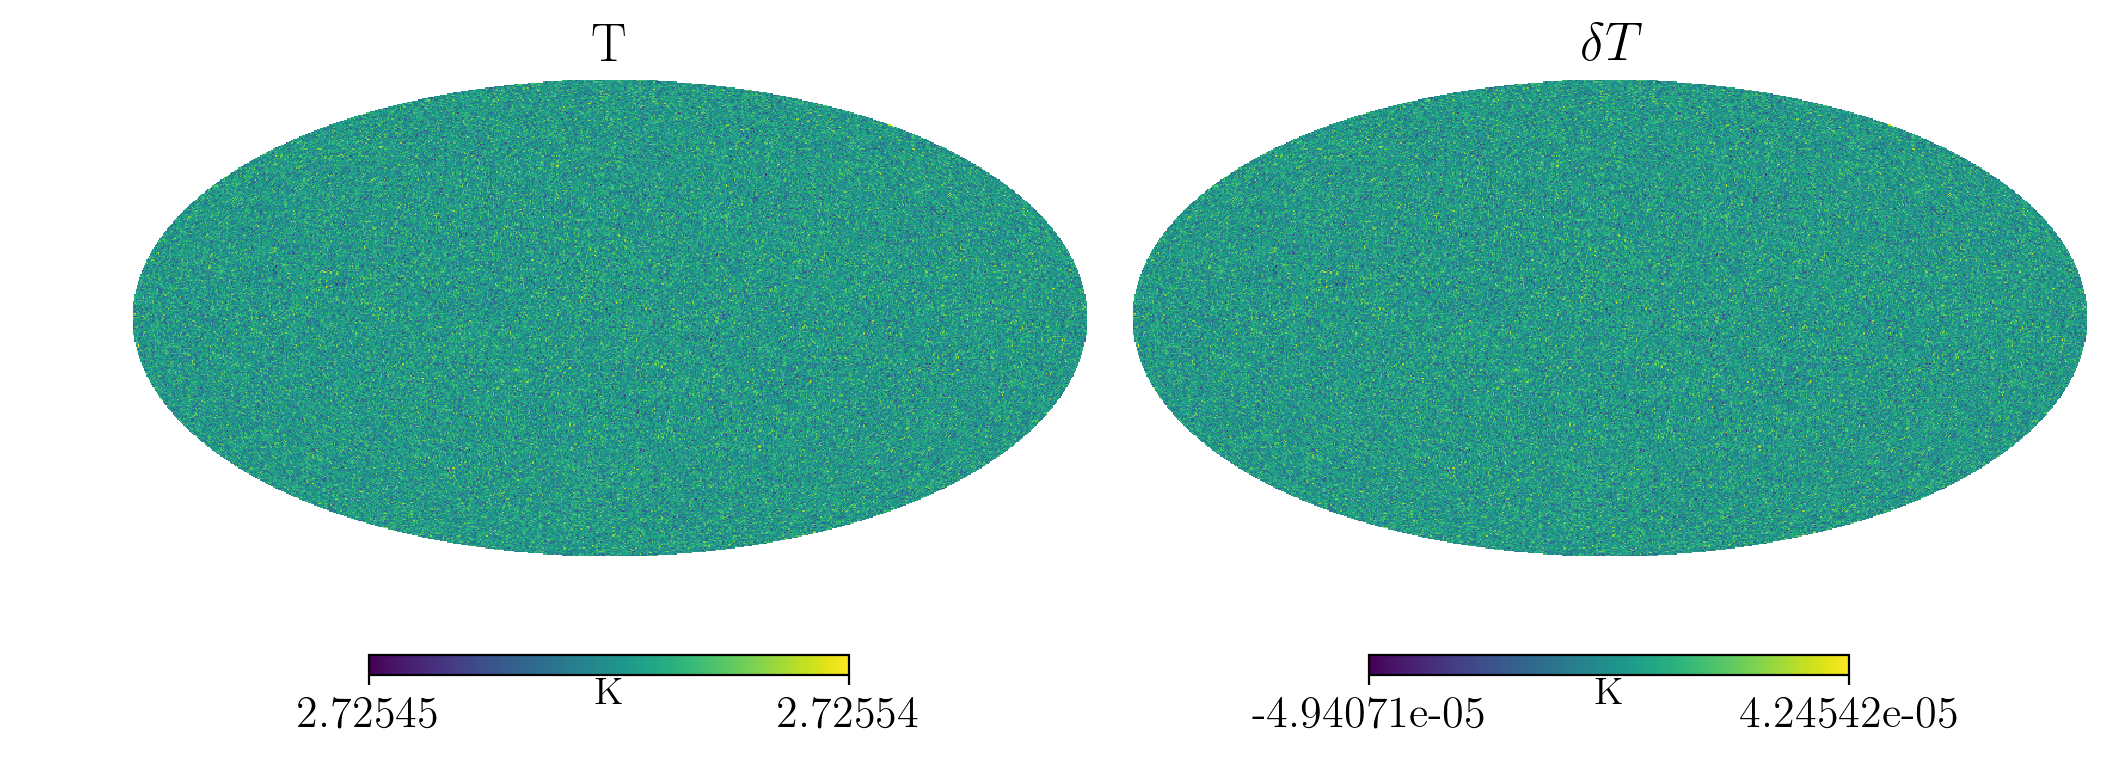

In [51]:
import healpy as hp 

NSIDE = 128
NPIX = hp.nside2npix(NSIDE)

dT = 1E-5 # :[K]
T_0 = 2.7255 # :[K]

# simulate the fluctuations (differential map)
dT_map = np.random.randn(NPIX)*dT
# and the absolute measurement map (including the average)
T_map = T_0+dT_map


plt.figure(figsize=(10,10),dpi=100)
hp.mollview(T_map,title="T",sub=(1,2,1),unit="K")
hp.mollview(dT_map,title="$\delta T$",sub=(1,2,2),unit="K")

We can convert this to intensity at a single frequency, or at multiple frequencies in one fell swoop:

In [100]:
frequencies = [100,143,217]

In [101]:
I_map = convert_units_of(T_map, from_units="T", to_units="I",
                         at_nu=frequencies,
                         with_map_avg=None,
                         is_differential=False)

dI_map = convert_units_of(dT_map, from_units="T", to_units="I",
                         at_nu=frequencies,
                         with_map_avg=T_0,
                         is_differential=True)


converting T [K] to I [MJy/sr]
T: brightness (T)emperature
I: specific (I)ntensity


converting dT [K] to dI [MJy/sr]
dT: (d)ifferential brightness (T)emperature
dI: (d)ifferential specific (I)ntensity



Now the returned maps have an extra dimension that indicates the observed frequency:

In [55]:
I_map.shape

(3, 196608)

By slicing the first dimension we can easily look at the maps at different frequencies. 

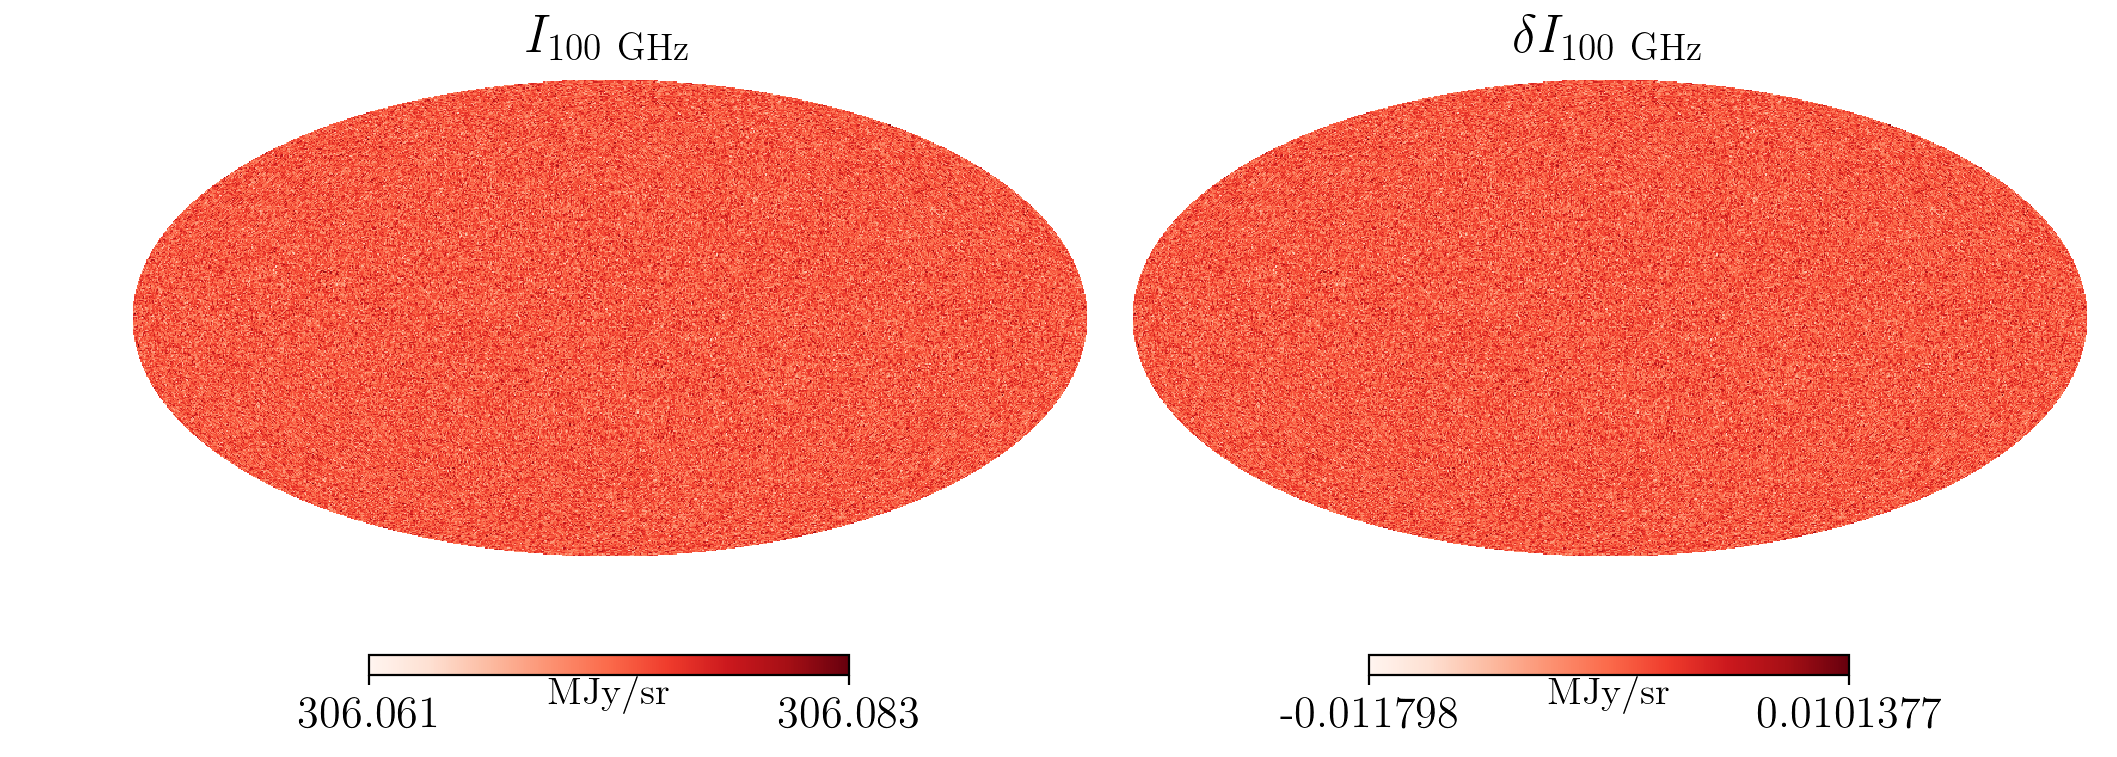

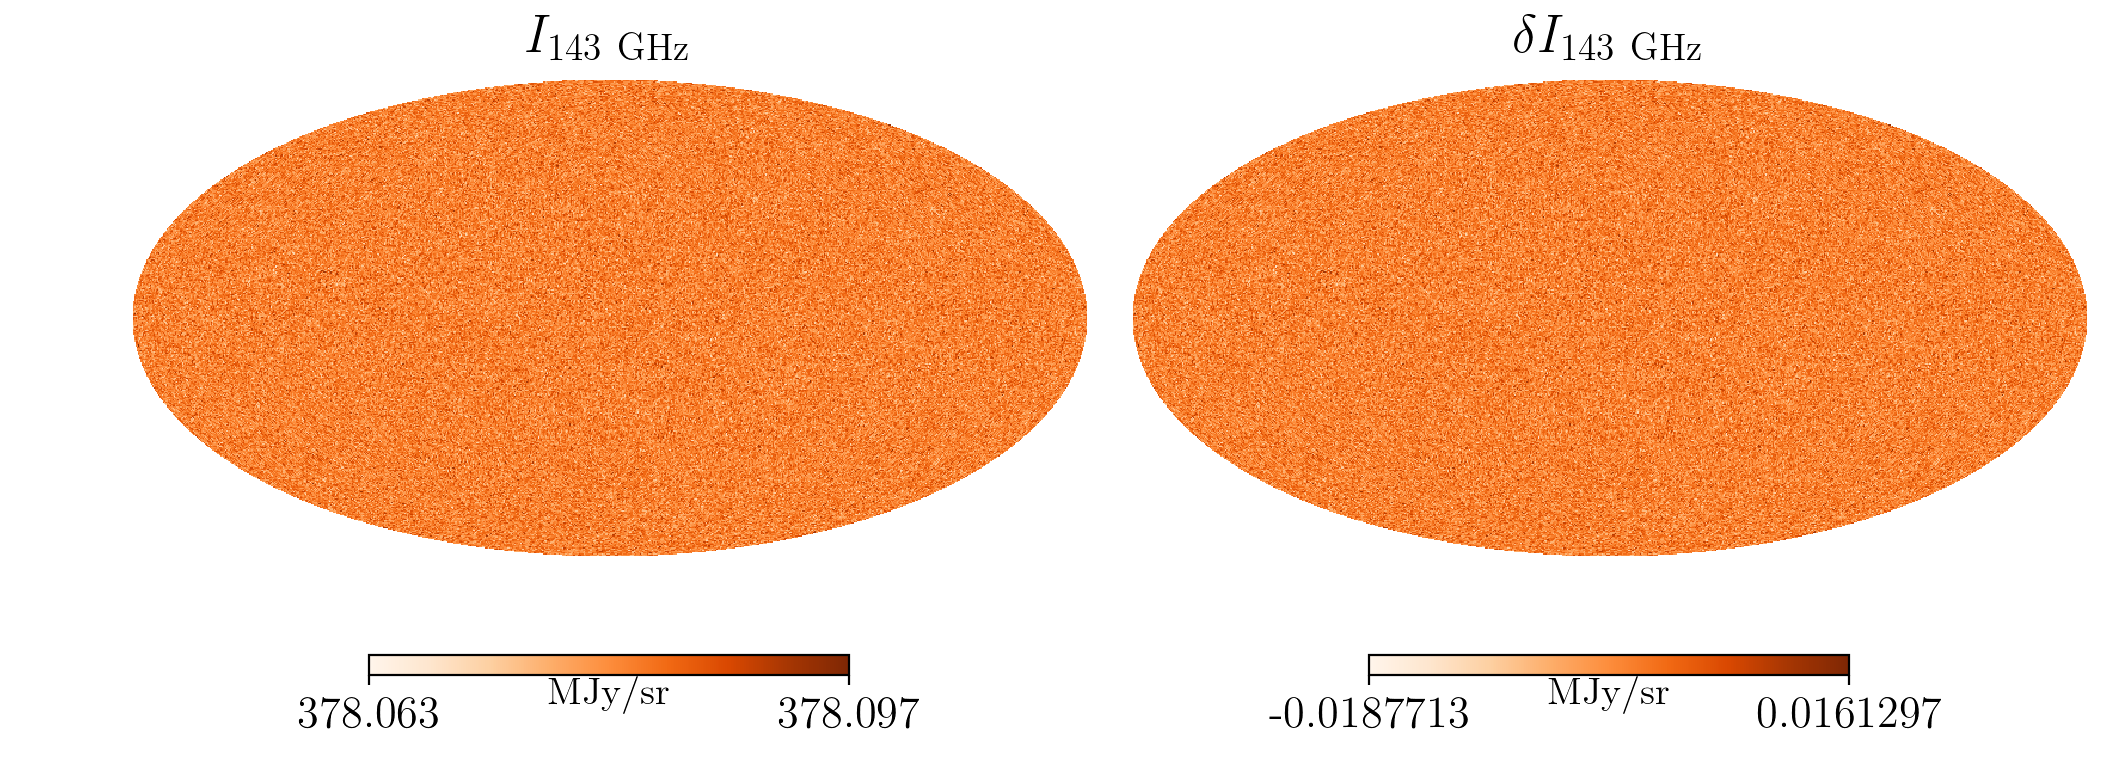

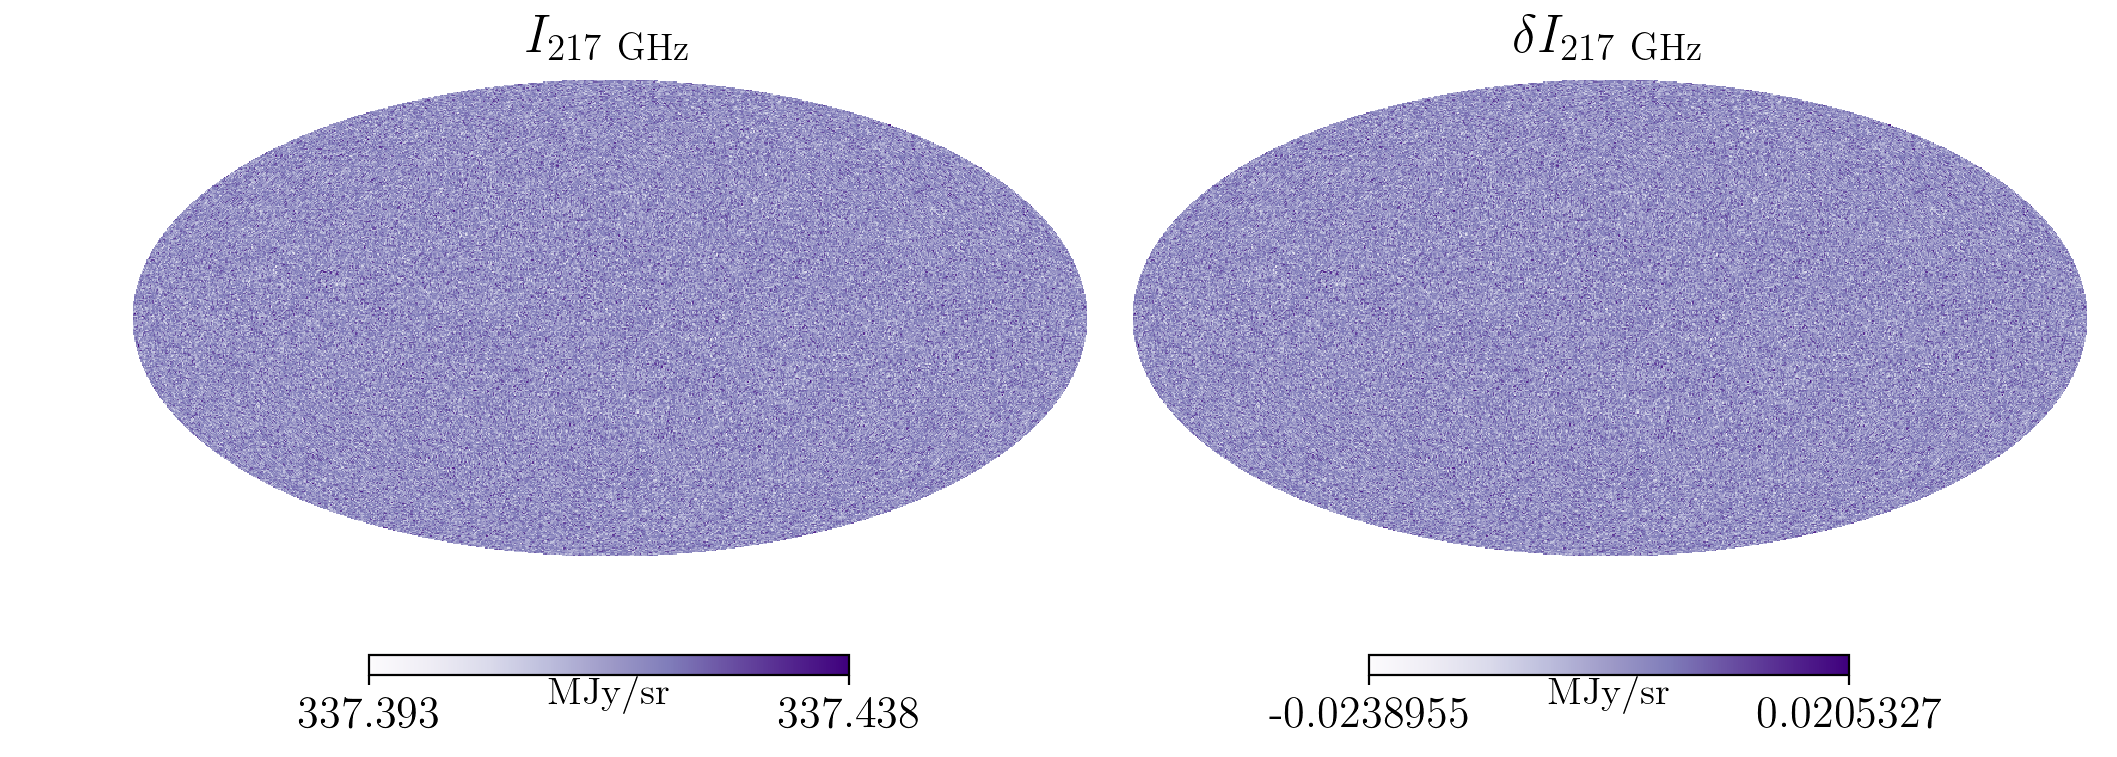

In [58]:
I_cmaps = [ cm.Reds, cm.Oranges, cm.Purples]
[cmap.set_under("w") for cmap in I_cmaps]

for i,nu in enumerate(frequencies):
    plt.figure(figsize=(10,10),dpi=100)
    hp.mollview(I_map[i],sub=(1,2,1),cmap=I_cmaps[i], title=r"$I_{%d~\rm GHz}$"%(nu),unit="MJy/sr")
    hp.mollview(dI_map[i],sub=(1,2,2),cmap=I_cmaps[i], title=r"$\delta I_{%d~\rm GHz}$"%(nu),unit="MJy/sr")

**Exercise**

Using `convert_units_of` to convert the temperature maps ($T$ and $\delta T$) to RJ temperature ($T_{RJ}$ and $\delta T_{RJ}$) at a few different frequencies. Do the same with the intensity maps calculated above ($I_\nu$ and $\delta I_\nu$) and check to see if the results are consistent. 

In [102]:
T_RJ_map = convert_units_of(T_map, from_units="T", to_units="T_RJ",
                         at_nu=frequencies,
                         with_map_avg=None,
                         is_differential=False)

dT_RJ_map = convert_units_of(dT_map, from_units="T", to_units="T_RJ",
                         at_nu=frequencies,
                         with_map_avg=T_0,
                         is_differential=True)


converting T [K] to T_RJ [K_RJ]
T: brightness (T)emperature
T_RJ: (R)ayleigh-(J)eans (T)emperature


converting dT [K] to dT_RJ [K_RJ]
dT: (d)ifferential brightness (T)emperature
dT_RJ: (d)ifferential (R)ayleigh-(J)eans (T)emperature




converting T_RJ [K_RJ] to T [K]
T_RJ: (R)ayleigh-(J)eans (T)emperature
T: brightness (T)emperature


converting dT_RJ [K_RJ] to dT [K]
dT_RJ: (d)ifferential (R)ayleigh-(J)eans (T)emperature
dT: (d)ifferential brightness (T)emperature



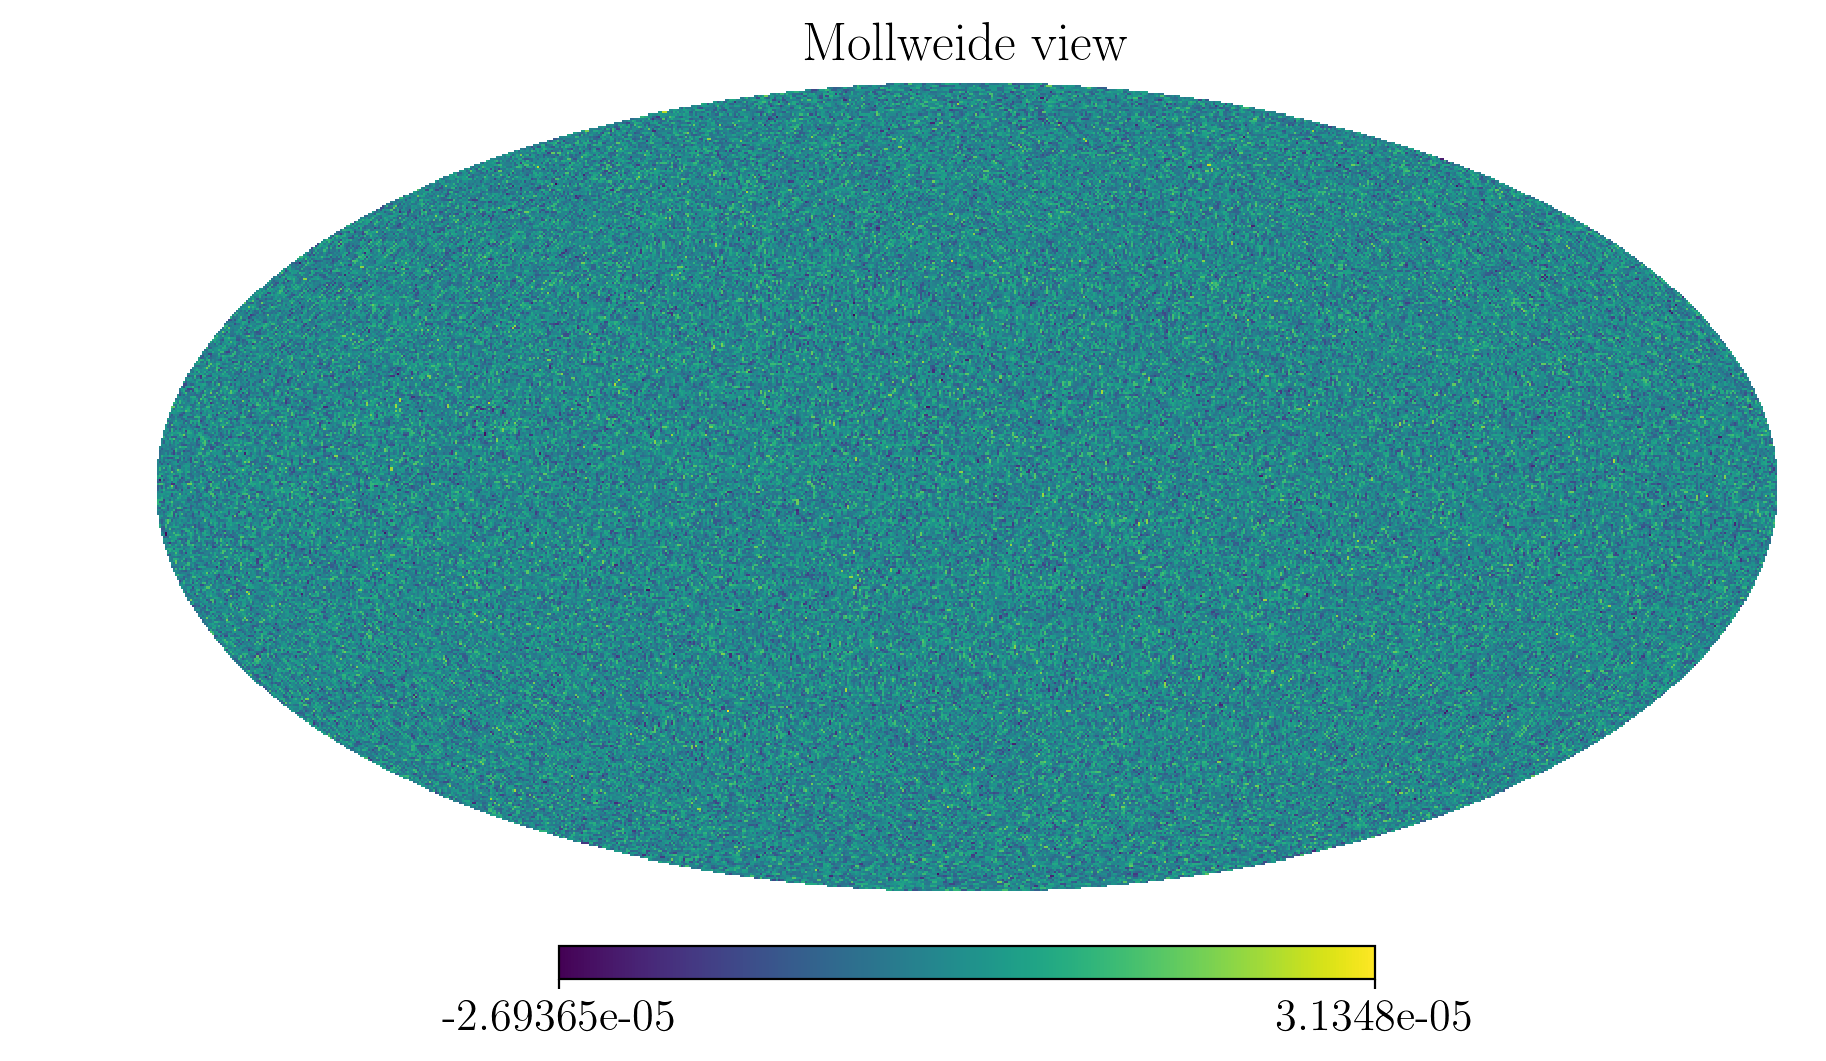

In [104]:
T_map2 = convert_units_of(T_RJ_map[0], from_units="T_RJ", to_units="T",
                         at_nu=100,
                         with_map_avg=None,
                         is_differential=False)


T_RJ0 = T_RJ_map.mean(axis=1)
I0 = I_map.mean(axis=1)


dT_map2 = convert_units_of(dT_RJ_map[0], from_units="T_RJ", to_units="T",
                         at_nu=100,
                         with_map_avg=T_RJ0[0],
                         is_differential=True)

hp.mollview(dT_map2-dT_map)